---
title: "✏️ Spring Term Summative"
author: "44800"
format: html
self-contained: true
math: mathjax
jupyter: python3
engine: jupyter
editor:
  render-on-save: true
  preview: true
---

In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from tqdm import tqdm  
import shap
from scipy.stats import chi2_contingency
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from wordcloud import WordCloud
from lets_plot import *
LetsPlot.setup_html()
import plotly.express as px
import pyLDAvis
import pyLDAvis.lda_model
from scipy.sparse import csr_matrix
from scipy import stats
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import umap_ as UMAP 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Load spaCy stopwords
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Disable unnecessary components for speed
stopwords = nlp.Defaults.stop_words

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Yuyao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Part 1: Similarity  
## 1.1. EDA, Data Cleaning

In [3]:
df = pd.read_json("train.jsonl", lines=True)
df.head()

,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text
0,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Opening of the sitting (first sitting of the n...,"Ladies and gentlemen, under the terms of the A...",None
1,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Election of the President of the European Parl...,"This morning, in accordance with the Rules of ...",None
2,Eva-Britt Svensson,MEP,GUE/NGL,en,sv,2009-07-14,2009,Election of the President of the European Parl...,"Mr President, ladies and gentlemen, I would l...",None
3,Jerzy Buzek,MEP,PPE,en,pl,2009-07-14,2009,Election of the President of the European Parl...,"Mr President, representatives of the Council ...",None
4,President,EUROPARL President,N/A,en,en,2009-07-14,2009,Election of the President of the European Parl...,I will now announce the result of the vote. Nu...,None


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106598 entries, 0 to 106597
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   speaker_name           106598 non-null  object        
 1   speaker_role           106598 non-null  object        
 2   speaker_party          106598 non-null  object        
 3   intervention_language  106598 non-null  object        
 4   original_language      106598 non-null  object        
 5   date                   106598 non-null  datetime64[ns]
 6   year                   106598 non-null  int64         
 7   debate_title           106598 non-null  object        
 8   text                   106598 non-null  object        
 9   translated_text        55546 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 8.1+ MB


The `'date'` and `'year'` columns are already in the correct format (`datetime64[ns]` and `int64`, respectively), so we do not need to convert them.  
  
For speeches originally in English (where `'translated_text'` was blank), we will copy the original text from `'text'` to `'translated_text'`. This gives us a consistent column of speeches (in English) to work with, which is important as comparing texts in different languages without translation would not be meaningful. 

In [5]:
# fill missing values in 'translated_text' with 'text' if no translation exists
df['translated_text'] = df['translated_text'].fillna(df['text'])

Let's also look at the other columns in the dataset:

In [6]:
df['speaker_party'].value_counts()

speaker_party
PPE           25446
S&D           20033
N/A           19417
ALDE           8937
ECR            7493
ID             6970
GUE/NGL        6780
Greens/EFA     6395
NI             5127
Name: count, dtype: int64

In [7]:
df['debate_title'].value_counts()

debate_title
Explanations of voteVideo of the speechesPV                                                                                                                                             17561
One-minute speeches on matters of political importance                                                                                                                                   1025
Explanations of vote Video of the speechesPV                                                                                                                                              927
Order of business                                                                                                                                                                         651
Question Time (Commission) Video of the speechesPV                                                                                                                                        376
                                     

Perhaps due to some error in the web scraping process to collect the data, some titles of the debates consistently have the same phrases (either "Video of the speechesPV" or "PV") at the end of the title. Not only are these phrases uninformative and make the titles less readable, they also lead to duplicates of the same title. We will remove these phrases from the titles using regex to make them more readable and consistent.

In [8]:
df['debate_title'] = (df['debate_title']
                      .str.replace(r'\s*Video of the speechesPV$', '', regex=True)
                      .str.replace(r'\s*PV$', '', regex=True)
)

In [9]:
# checking the unique values in 'debate_title' after cleaning
df['debate_title'].value_counts().head(20)

debate_title
Explanations of vote                                                                                                                                                                                                                                                                                          18812
One-minute speeches on matters of political importance                                                                                                                                                                                                                                                         1025
Order of business                                                                                                                                                                                                                                                                                               780
State of the Union (debate)                                    

In [10]:
df['speaker_role'].value_counts()

speaker_role
MEP                             87181
N/A                             16061
EUROPARL President               1569
EU Commissioner                  1039
EU Council President              325
EU Commission Vice-President      248
EU Commission President           175
Name: count, dtype: int64

I chose to focus all subsequent analysis only on **speeches delivered by Members of the European Parliament (MEPs)**. These are elected party representatives from the 27 EU member states and their **speeches reflect their party's positions and rhetoric**, which is the focus of our analysis.  
  
The president/ vice presidents of the European Parliament (EP) chairs plenary sittings, so their language tends to be neutral, prodcedural, or administrative and do not reflect any party's stance. Commissioners are part of the EU executive and do not represent parties in the EP. While individual commissioners may have political leanings, their official speches are meant to reflect the Commisioner's position, not a party's. The EU Council President represents the Council of the European Union, not the Parliament, so their speeches are more institutional and might not align with party discourse. Hence, we will not include speeches from these speakers in our analysis.  

Lastly, for speakers whose roles were labelled as "N/A", when inspecting the dataset, they are mostly the president/ vice presidents of the European Parliament (EP) and were simply mislabelled. Even if they might be MEPs and were mislabelled, the size of this group is small compared to the amount of MEP speeches we have in the dataset, so we will also not include them in our analysis.  
  
As such, we will filter the dataset to only include speeches from MEPs.  


In [11]:
mep_df = df[df['speaker_role'] == 'MEP']
mep_df['speaker_party'].value_counts()

speaker_party
PPE           25446
S&D           20033
ALDE           8937
ECR            7493
ID             6970
GUE/NGL        6780
Greens/EFA     6395
NI             5127
Name: count, dtype: int64

To get an initial sensing of the data, let's first sample 800 speeches from each party. Uneven distribution of speeches among parties can bias the analysis, so sampling equal numbers helps create a balanced dataset and prevents overrepresentation of parties with more speeches (such as PPE and S&D who dominate the dataset).

In [12]:
# balanced sample of speeches from each political party
def balanced_sample(mep_df, party_column, sample_size):
    # Get unique parties
    parties = mep_df[party_column].unique()
    
    # Create an empty DataFrame to hold the sampled data
    sampled_df = pd.DataFrame()
    
    # Loop through each party and sample the specified number of speeches
    for party in parties:
        party_df = mep_df[mep_df[party_column] == party]
        sampled_party_df = party_df.sample(n=sample_size, random_state=42)
        sampled_df = pd.concat([sampled_df, sampled_party_df])
    
    return sampled_df.reset_index(drop=True)

# Sample 800 speeches from each party
sampled_df = balanced_sample(mep_df, 'speaker_party', 800)

sampled_df.head()



,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text
0,Anja Hazekamp,MEP,GUE/NGL,nl,nl,2021-06-07,2021,EU Biodiversity Strategy for 2030: Bringing na...,"– Voorzitter, de natuur verkeert in een ongek...","“President, nature is in an unprecedented cri..."
1,Manu Pineda,MEP,GUE/NGL,es,es,2022-10-05,2022,Russia’s escalation of its war of aggression a...,"– Señora presidenta, señora presidenta de la ...","– Mrs. President, Mrs. President of the Commi..."
2,Pernando Barrena Arza,MEP,GUE/NGL,en,en,2022-07-06,2022,The UK government’s unilateral introduction of...,"– Mr President, with the creation of Northern...","– Mr President, with the creation of Northern..."
3,João Ferreira,MEP,GUE/NGL,en,pt,2010-07-07,2010,Explanations of vote,The regulation on novel foods is intended to ...,The regulation on novel foods is intended to ...
4,Miguel Portas,MEP,GUE/NGL,en,pt,2011-06-07,2011,Explanations of vote,This directive makes provision for Member Sta...,This directive makes provision for Member Sta...


Another data cleaning step is to remove any speeches that are not in English due to a lack of translation/ partial translation. Let's check how many of such speeches there are in our sampled dataset:

In [13]:
# Add the language detector to SpaCy pipeline
@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('language_detector', last=True)

# Function to check if text is in English
def check_english(text):
    doc = nlp(text)
    return doc._.language['language'] == 'en'

# Apply tqdm for progress monitoring
tqdm.pandas(desc="Checking language")

# Apply the function with tqdm progress bar
sampled_df['is_english'] = sampled_df['translated_text'].progress_apply(check_english)

# Display the counts of English vs non-English
sampled_df['is_english'].value_counts()

Checking language: 100%|██████████| 6400/6400 [01:43<00:00, 61.69it/s]


is_english
True     6394
False       6
Name: count, dtype: int64

In [14]:
# see which speeches are not in English
non_english_speeches = sampled_df[sampled_df['is_english'] == False]
non_english_speeches

,speaker_name,speaker_role,speaker_party,intervention_language,original_language,date,year,debate_title,text,translated_text,is_english
923,Roberta Metsola,MEP,PPE,et,et,2015-01-15,2015,Ombudsman's annual report 2013 (debate),Nixtieq nibda billi nirringrazzja lill-kollega...,Nixtieq nibda billi nirringrazzja flower-with ...,False
1967,Alex Agius Saliba,MEP,S&D,et,mt,2019-11-27,2019,"Situation in Israel and Palestine, including t...","– Sur President, ser immur dritt għall-punt. ...","– Sur President, sir immur dritt għall-punt. ...",False
2071,Cyrus Engerer,MEP,S&D,et,mt,2021-09-16,2021,"EU transparency in the development, purchase a...","– Sur President, ninsab kuntent ħafna li qed ...","– Sur President, ninsab kuntent ħafna li qed ...",False
2210,Marlene Mizzi,MEP,S&D,et,it,2016-02-25,2016,Activities of the European Ombudsman in 2014 (...,"F'sena waħda, aktar minn 23 000 ċittadin talbu...","F'sena waħda, actar min 23 000 ċittadin talbu ...",False
2267,Josianne Cutajar,MEP,S&D,et,mt,2020-07-23,2020,Conclusions of the extraordinary European Coun...,bil-miktub. – Hu tragward sabiħ għall-Ewropa; ...,by Mick. – Hu tragward sabiħ għall-Ewropa; Int...,False
4286,Angel Dzhambazki,MEP,ECR,en,en,2023-06-15,2023,Call for a European strategy to counter hostag...,– So you are asking me not to say what I want...,– So you are asking me not to say what I want...,False


Since the number of speeches without an English translation is small relative to the total number of speeches, we can drop them without significantly affecting the analysis:

In [15]:
sampled_df = sampled_df[sampled_df['is_english'] == True].reset_index(drop=True)

## 1.2. Preliminary Text Preprocessing and Tokenisation  
Our preliminary text preprocessing steps will include:  

- Lowercasing the text
- Removing punctuation
- Removing stopwords included in spaCy's English stopword list  
  
Removing stopwords is important as they are common words that do not carry significant meaning and can introduce noise into the analysis. For example, words like "the", "is", and "and" are often used in speeches but do not provide much information about the speaker's stance or the topic being discussed.   
  
Then, using `CountVectorizer`, we will create a document frequency matrix (DFM) of the speeches. The DFM is a matrix representation of the text data, where each row corresponds to a speech and each column corresponds to a unique word in the corpus. The values in the matrix represent the **raw frequency** of each word in each speech, which is useful for understanding the most common words used by different parties.  

I also chose to only focus on **bigrams and trigrams** (two- and three-word phrases) by setting the `ngram_range` parameter to `(2, 3)`. This is because bigrams and trigrams can capture more context and meaning than unigrams (single words), which can be important for understanding the nuances of political discourse. For example, the phrase "human rights" is more informative than the individual words "human" and "rights" on their own. I also set a minimum document frequency of 5 (`min_df=5`) to remove rare tokens that could introduce noise into the analysis. 

In [16]:
def preprocess_speeches(speeches):
    tokenized_speeches = []
    
    for speech in tqdm(speeches, desc="Processing Speeches", total=len(speeches)):
        doc = nlp(speech.lower())
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        tokenized_speeches.append(" ".join(tokens))
    
    return tokenized_speeches

# Apply preprocessing
tokenized_speeches = preprocess_speeches(sampled_df['translated_text'])

# Create CountVectorizer DFM with unigrams, bigrams, and trigrams
count_vectorizer = CountVectorizer(ngram_range=(2,3), min_df=5) 

X_count = count_vectorizer.fit_transform(tokenized_speeches)

# Convert to DataFrame
df_count = pd.DataFrame(X_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display sample output
df_count.head()

Processing Speeches: 100%|██████████| 6394/6394 [01:28<00:00, 71.90it/s]


,000 billion,000 death,000 euro,000 hectare,000 job,000 migrant,000 people,000 people die,000 refugee,000 ton,...,young people unemployed,young people want,young people woman,young person,young woman,youth employment,youth guarantee,youth unemployment,zero emission,zero tolerance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's plot the DFM as a word cloud to help us visually identify the most frequently used words in the speeches: 

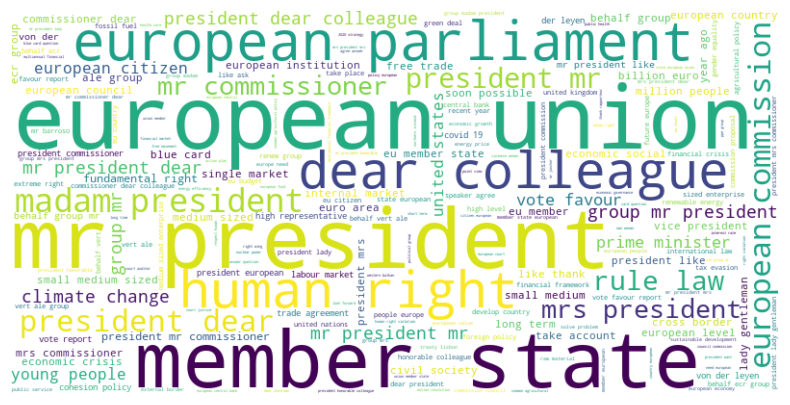

In [17]:
# Sum counts across all documents
word_counts = df_count.sum(axis=0).sort_values(ascending=False)

# Convert to dictionary (for WordCloud)
word_freq = word_counts.to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This word cloud is still not particularly informative as it contains a lot of **common words specific to the context of parliamentary plenary speeches** (that would not be removed by the spaCy stopword list). For example, we see a lot of **procedural/ institutional phrases or formalities** that are very common across all parties and debates and hence dominate the word cloud. These include "Mr/ Madam President", "Dear honourable colleagues", "Ladies and gentlemen", "blue card" (procedure to interrupt speeches). Since this is the EP, the phrases "European Parliament", "European Union", "European Commission", "member states" are also very common and do not provide substantive ideological content.  

Regex is useful for this as we can use it to identify and remove these common phrases (*and its variations*) from the speeches. We will add this step of removing data-specific stopwords and redo the tokenisation and DFM creation.  


In [18]:
stop_phrases = [
    r"\bmr\.?\s+president\b", r"\bmrs\.?\s+president\b",
    r"\bmadam\.?\s+president\b", r"\bdear\s+colleagues?\b",
    r"\beuropean\s+(union|parliament|commission)\b",
    r"\bmember\s+states\b", r"\bpresident\s+mr\b", 
    r"\bmr\.?\s+commissioner\b", r"\bmrs\.?\s+commissioner\b", 
    r"\blad(y|ies)\s+(and\s+)?gentlemen\b", r"\bon\s+behalf\s+(of\s+(the\s+)?)?[A-Za-z0-9/+-]+\s+group\b", 
    r"\bhonou?rable\s+colleagues?\b", r"\bblue[\s\-]+card\b"
]
stop_pattern = re.compile("|".join(stop_phrases), flags=re.IGNORECASE)

def preprocess_speeches_cleaned(speeches):
    cleaned_speeches = []
    for speech in tqdm(speeches, desc="Processing Speeches", total=len(speeches)):
        # Remove stop phrases first
        speech_clean = stop_pattern.sub("", str(speech))
       
        doc = nlp(speech_clean.lower())
        tokens = [
            token.lemma_ for token in doc 
            if not token.is_stop and not token.is_punct and token.is_alpha
        ]
        cleaned_speeches.append(" ".join(tokens))
    return cleaned_speeches

# Apply preprocessing
tokenized_speeches_cleaned = preprocess_speeches_cleaned(sampled_df['translated_text'])

Processing Speeches:   0%|          | 0/6394 [00:00<?, ?it/s]

Processing Speeches: 100%|██████████| 6394/6394 [01:28<00:00, 72.63it/s]


In [19]:
X_count = count_vectorizer.fit_transform(tokenized_speeches_cleaned)
# Convert to DataFrame
df_count = pd.DataFrame(X_count.toarray(), columns=count_vectorizer.get_feature_names_out())
df_count.head()

,able access,able act,able afford,able agree,able benefit,able build,able buy,able compete,able deal,able decide,...,young people unemployed,young people want,young people woman,young person,young woman,youth employment,youth guarantee,youth unemployment,zero emission,zero tolerance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Often, TF-IDF is more useful than raw frequency for text analysis as it **captures how important a word is to a document relative to the entire corpus**. It does this by weighing the frequency of each word in a speech against its frequency across all speeches, which helps to highlight words that are more unique to each speech. **Raw counts are also biased towards longer speeches**, as they will naturally have more words, whereas TF-IDF normalises for that. Let's obtain a TF-IDF DFM using `TfidfVectorizer` and with the same n-gram range and minimum document frequency parameters as before:


In [20]:
tfidf_vectoriser = TfidfVectorizer(ngram_range=(2,3), min_df=5)
X_tfidf = tfidf_vectoriser.fit_transform(tokenized_speeches_cleaned)

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectoriser.get_feature_names_out())
df_tfidf.head()

,able access,able act,able afford,able agree,able benefit,able build,able buy,able compete,able deal,able decide,...,young people unemployed,young people want,young people woman,young person,young woman,youth employment,youth guarantee,youth unemployment,zero emission,zero tolerance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We also add the corresponding metadata to the DFM so that we know the context of the speeches. `'text'` is not included as we already have all the speeches in English under `'translated_text'`. 

In [21]:
metadata_columns = sampled_df.drop(columns=['text'])

df_tfidf_with_metadata = pd.concat([df_tfidf, metadata_columns], axis=1)

## 1.3. Top Tokens by Party (using TF-IDF scores)  
We look at the top 10 tokens by party using the mean TF-IDF scores. This gives us an idea of what characterises each party's discourse and which phrases are most indicative of each party's speech patterns and ideological focus.

In [22]:
tokens_columns = df_tfidf.columns

# Helper function to get top 10 tokens for a specific party
def get_top_10_tokens_for_party(df_tfidf_with_metadata, party, tokens_columns):
    # Filter for the specific party
    df_party = df_tfidf_with_metadata[df_tfidf_with_metadata['speaker_party'] == party]
    
    # Compute average TF-IDF per token
    mean_tfidf_for_party = df_party[tokens_columns].mean()
    
    # Get top 10 tokens with highest average TF-IDF
    top_10_tokens_party = mean_tfidf_for_party.sort_values(ascending=False).head(10)
    
    return top_10_tokens_party.index.tolist()

# Apply across all unique parties
top_tokens_list = [
    get_top_10_tokens_for_party(df_tfidf_with_metadata, party, tokens_columns)
    for party in df_tfidf_with_metadata['speaker_party'].unique()
]

# Create DataFrame
top_tokens_df = pd.DataFrame(top_tokens_list, columns=[f"Token{i+1}" for i in range(10)])

# Add the party name
top_tokens_df['Party'] = df_tfidf_with_metadata['speaker_party'].unique()

# Reorder columns
top_tokens_df = top_tokens_df[['Party'] + [col for col in top_tokens_df.columns if col != 'Party']]

# View result
print(top_tokens_df)

        Party       Token1          Token2             Token3  \
0     GUE/NGL  human right  climate change      united states   
1         PPE  vote favour     human right      favour report   
2         S&D  human right  climate change       behalf group   
3        ALDE  renew group     human right     climate change   
4  Greens/EFA  human right        rule law  fundamental right   
5         ECR     rule law     human right          ecr group   
6          ID  vote favour     human right      united states   
7          NI  human right     vote favour           rule law   

               Token4          Token5            Token6            Token7  \
0      public service   extreme right       vote report        right wing   
1  vote favour report  climate change          rule law      member state   
2         vote favour    young people          rule law       vote report   
3            rule law  prime minister  european citizen   internal market   
4      prime minister  climat

We can already see some similarities and differences in the ideological focus between parties, but let us visualise these top tokens in a bar plot to make it clearer and to see the magnitude of the differences. 

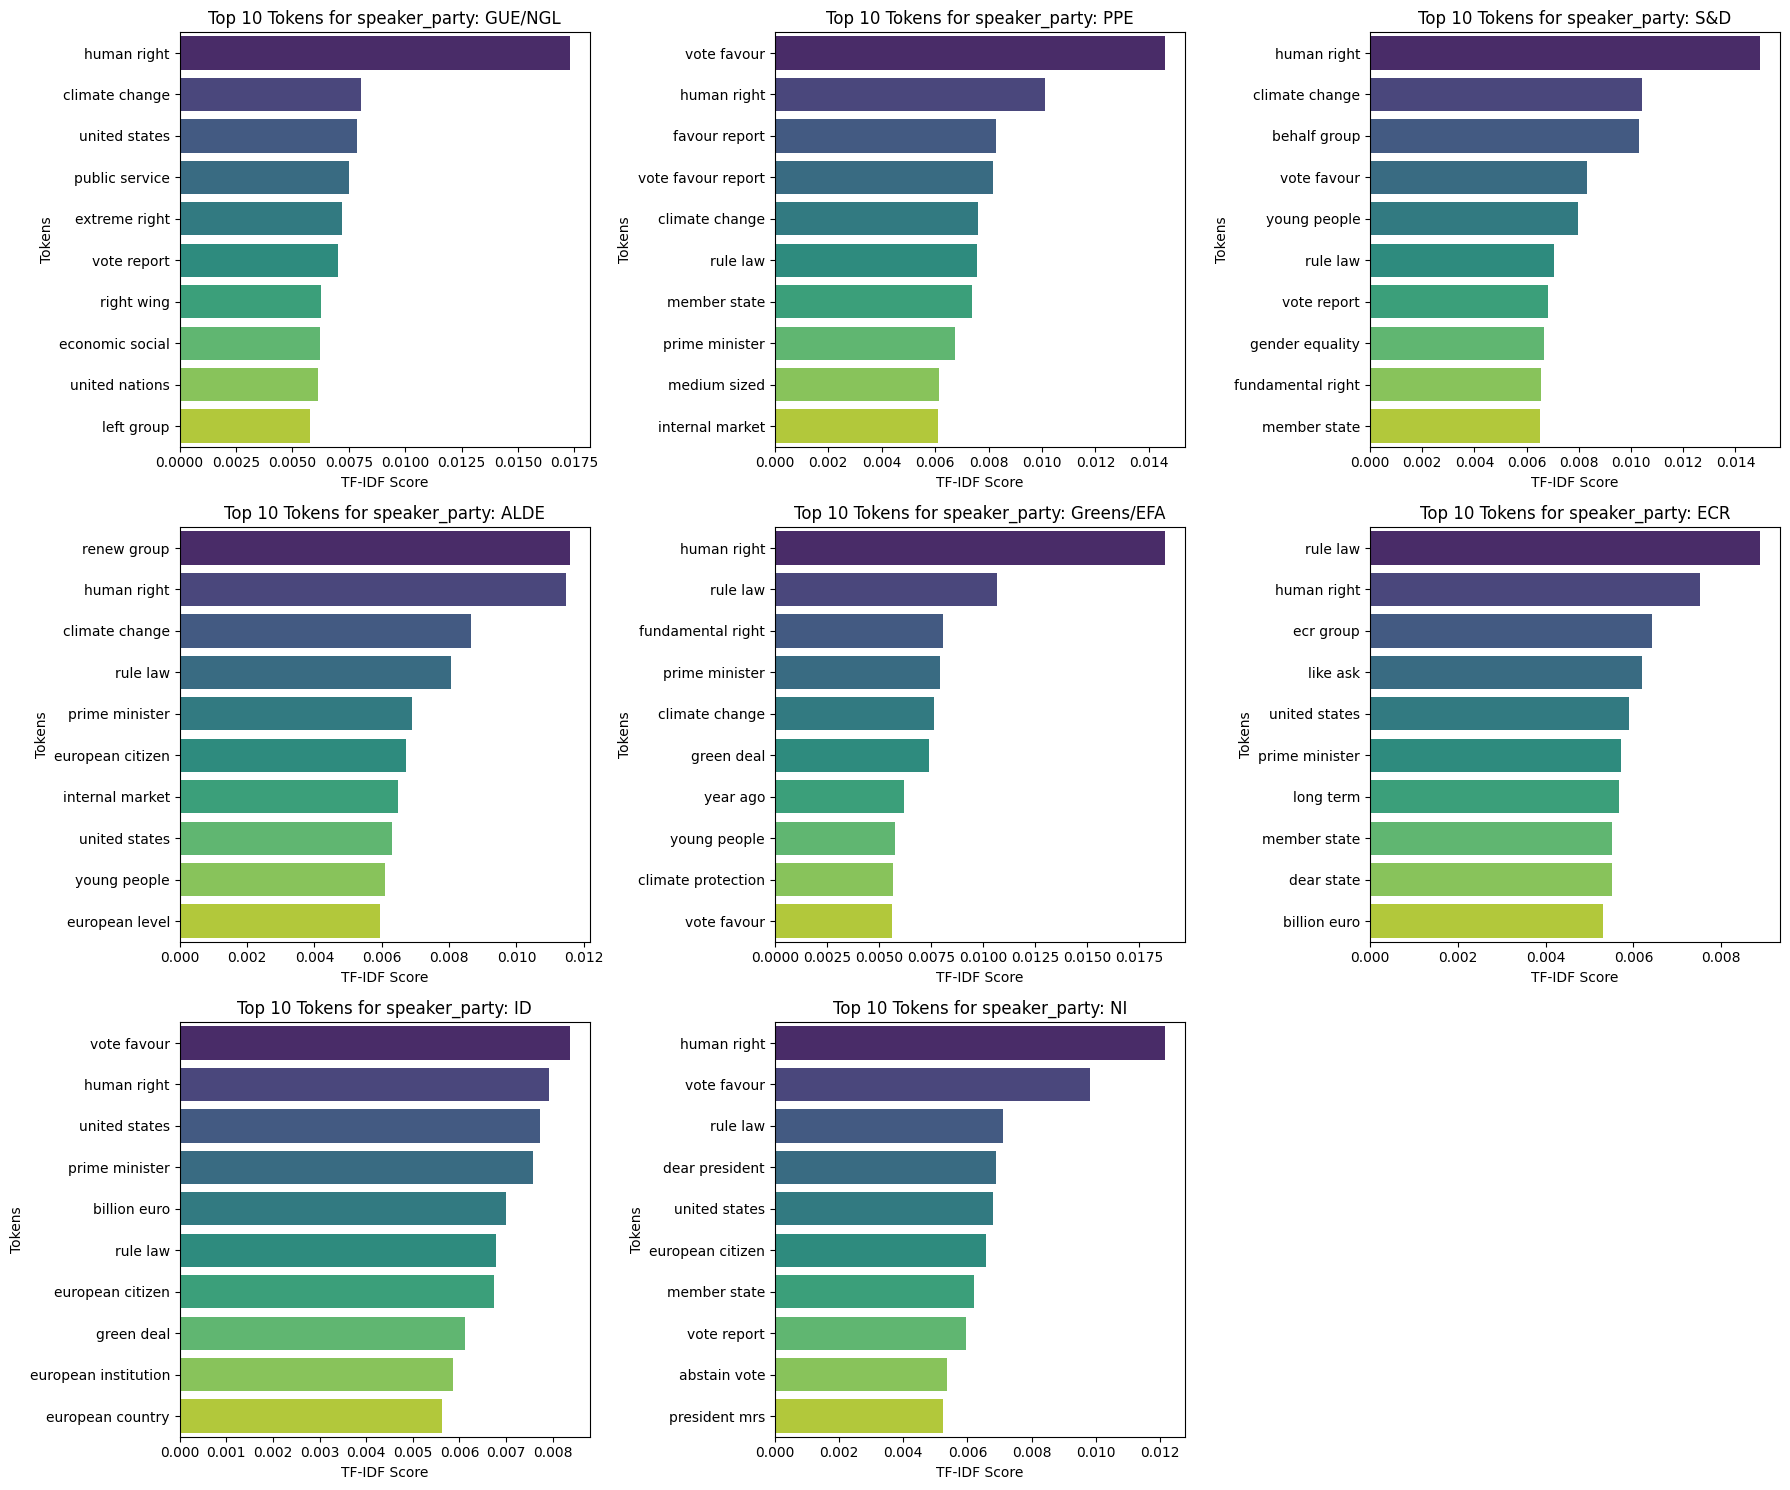

In [23]:
def plot_top_10_tokens_for_group(df_tfidf_with_metadata, group_value, tokens_columns, group_col, ax):
    # Get top 10 tokens for the specific group value
    top_10_tokens = get_top_10_tokens_for_party(df_tfidf_with_metadata, group_value, tokens_columns)
    
    # Extract mean TF-IDF values for these tokens
    df_group = df_tfidf_with_metadata[df_tfidf_with_metadata[group_col] == group_value]
    mean_tfidf_for_group = df_group[tokens_columns].mean()
    
    # Get the TF-IDF scores of the top 10 tokens
    top_10_scores = mean_tfidf_for_group[top_10_tokens].sort_values(ascending=False)
    
    # Plot the bar chart in the provided axis
    sns.barplot(x=top_10_scores.values, y=top_10_scores.index, hue=top_10_scores.index, palette="viridis", ax=ax)
    ax.set_title(f"Top 10 Tokens for {group_col}: {group_value}")
    ax.set_xlabel("TF-IDF Score")
    ax.set_ylabel("Tokens")

def plot_all_groups_top_tokens_side_by_side(df_tfidf_with_metadata, tokens_columns, group_col):
    unique_groups = df_tfidf_with_metadata[group_col].dropna().unique()
    num_groups = len(unique_groups)
    
    # Set number of subplot columns
    cols = 3
    rows = (num_groups + cols - 1) // cols

    # Create subplot grid
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, rows * 5))
    axes = axes.flatten()

    # Plot for each group
    for i, group_value in enumerate(unique_groups):
        plot_top_10_tokens_for_group(df_tfidf_with_metadata, group_value, tokens_columns, group_col, axes[i])
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_all_groups_top_tokens_side_by_side(df_tfidf_with_metadata, tokens_columns, group_col='speaker_party')

### 1.3.1 Interpretation of Top Tokens by Party  
**Shared themes across the political spectrum**  
Across nearly all political groups in the EP, there is a visible **rhetorical convergence around core democratic values, human rights, and climate concerns**. Notably, terms such as *"human right(s)", "rule (of) law"*, and *"climate change"* consistently appear in the top 10 tokens across parties. This likely reflects the institutional priorities of the European Parliament, where democratic norms, environmental sustainability, and human rights are **central pillars of legislative debate and policy formation** [^1].   
[^1]: https://european-union.europa.eu/priorities-and-actions/eu-priorities/european-union-priorities-2024-2029_en  

**Left-wing parties**  
GUE/NGL and S&D, as expected from parties on the left of the political spectrum, prioritise language centered on **social equity, public service, and multilateral cooperation**:  

* GUE/NGL (also known as The Left in the European Parliament) features terms like *“united states”, “united nations”, “public service”, “right wing”*, and *“economic social”*, signaling a strong internationalist, anti-austerity, and class-based discourse. They also tend to explicitly critique their opponents and neoliberal policies, as seen in terms like *"extreme right" and "right-wing"*.  

* S&D includes terms like *“gender equality"* and *"young people"*, aligning with progressive values, support for youth, and gender equality.   
  
**Greens/EFA**  
Unsurprisingly, Greens/EFA is the **only party** where **environmental terminology** like *“green deal”, “climate protection”*, and *“climate change”* dominates multiple top slots. *“Young people”* and *“fundamental right”* also reinforce their progressive, intergenerational, and rights-based framing of politics. Their use of *“year ago”* may relate to referencing longitudinal environmental trends or policy timelines. All in all, the top TF-IDF tokens pretty accurately reflect the party's core mission of ecological sustainability, civil liberties, and democratic reforms. 
  
**Centrist and liberal parties**  
PPE and ALDE (also known as Renew Europe) show a **more centrist and pro-European Union** rhetoric. PPE features terms like *"medium sized"* and *"internal market"* and ALDE terms like *"internal market"*, *"european citizen"* and *"european level"*. These tokens highlight their support for **EU integration, economic liberalism**, and **market-oriented policies**, consistent with their roles as centrist and centre-right forces within the EP. The presence of *"internal market"* in both parties' top tokens suggests a **shared focus on economic cohesion within the EU**.  
  
**Right-wing and nationalist parties**  

* ID's top terms include *"european citizen", "european institution"* and *"european country"*, clearly indicating a **nationalist and hard Eurosceptic** stance that the ID party is known for. The term *"billion euro"* may also reflect a critique of EU institutions and spending, aligning with their anti-EU rhetoric. 

* The ECR promotes **soft Euroscepticism and national sovereignty**. Other than the term *"billion euro"*, possibly critiquing EU spending, the other top tokens do not seem to clearly align with the stance that the party is known to take. 

* NI (non-inscrits) comprises of unaffliated or fringe members, so their top tokens show more varied and non-cohesive terminology. The fact that *"abstain vote"* appears in its top tokens (which is not the case for any other party) may signal protest participation or a lack of commitment to party lines.  

Comparing the left and right wing parties, we see that the left-wing parties (GUE/NGL and S&D) tend to focus on **social and environmental issues**, while the right-wing parties (ID, ECR, and NI) focus on **nationalism** and **Euroscepticism**. This is consistent with their ideological positions, where left-wing parties advocate for social justice and equality, while right-wing parties often prioritise national sovereignty and anti-EU sentiments.  
  
**Caveat: context and semantics matter!**  
While TF-IDF gives us a simple and interpretable way to identify distinctive terms based on their frequency and distribution, it treats words as isolated tokens, **ignoring their semantic meaning or syntactic role**. For instance, terms like *“united states”, “prime minister”*, or *“climate change”* may appear across multiple parties' top tokens, but the stance each party takes on these issues—supportive, critical, or neutral—remains opaque. Similarly, a party mentioning *“human rights”* frequently may be advocating for expansion of protections, while another may be criticising perceived overreach. TF-IDF cannot distinguish between these uses, leading to potentially misleading interpretation of results that conflate shared vocabulary with shared ideology.


## 1.4. Preliminary Similarity Analysis (with TF-IDF)  
While the top 10 tokens by party (section 1.3) give us a good idea of the **ideological focus** of each party, it does not give us a measure of how similar or different the parties are from each other. To do this, we will use the **cosine similarity** metric to measure the similarity between speeches. Cosine similarity is a common metric used in text analysis to measure the similarity between two documents based on their vector representations. With TF-IDF, cosine similarity helps compare speeches based on shared important terms. Unlike other common metrics like Euclidean distance or Manhatten distance, cosine similarity is not affected by the length of the speeches, making it a more appropriate choice for our analysis as speeches can vary significantly in length and verbosity.  
  
Since we have 6393 speeches in our sampled dataset, computing the cosine similarity matrix for all speeches would result in a 6393 x 6393 matrix. Typically we are more interested in the most similar/ dissimilar pairs of speeches to look at how speeches within/ across parties differ or converge, so for efficiency, we will define the following two functions, `get_similar_pairs` and `get_dissimilar_pairs`, to compute the cosine similarity for only the most similar and dissimilar pairs of speeches. We will set the threshold for similarity to 0.8 and for dissimilarity to 0.05. 

In [24]:
def get_similar_pairs(similarity_matrix, threshold=0.8):
    # Get upper triangle indices
    upper_triangle_indices = np.triu_indices(similarity_matrix.shape[0], k=1)
    
    # Get pairs and their similarity scores
    pairs = list(zip(upper_triangle_indices[0], upper_triangle_indices[1]))
    scores = similarity_matrix[upper_triangle_indices]
    
    # Filter pairs based on threshold
    similar_pairs = [(pairs[i], scores[i]) for i in range(len(scores)) if scores[i] >= threshold]
    
    return similar_pairs

In [25]:
def get_dissimilar_pairs(similarity_matrix, threshold=0.05):
    # Get upper triangle indices
    upper_triangle_indices = np.triu_indices(similarity_matrix.shape[0], k=1)
    
    # Get pairs and their similarity scores
    pairs = list(zip(upper_triangle_indices[0], upper_triangle_indices[1]))
    scores = similarity_matrix[upper_triangle_indices]
    
    # Filter pairs based on threshold
    dissimilar_pairs = [(pairs[i], scores[i]) for i in range(len(scores)) if scores[i] <= threshold]
    
    return dissimilar_pairs

In [26]:
cosine_sim_matrix = cosine_similarity(X_tfidf)

# get pairs of speeches with similarity above 0.8
similar_pairs_tfidf = get_similar_pairs(cosine_sim_matrix, threshold=0.8)
similar_pairs_tfidf_df = pd.DataFrame(similar_pairs_tfidf, columns=['Pair', 'Similarity'])

`similar_pairs_tfidf_df` only contains the index of the speeches and the pairwise similarity scores, so we will add the corresponding metadata to the dataframe to make it more informative. 

In [27]:
def fetch_metadata(df, pairs, sim_matrix):
    # Convert columns to numpy arrays for faster access
    speaker_names = df['speaker_name'].to_numpy()
    speaker_parties = df['speaker_party'].to_numpy()
    dates = df['date'].to_numpy()
    debate_titles = df['debate_title'].to_numpy()
    speeches = df['translated_text'].to_numpy()

    # Build metadata using list comprehension 
    metadata = [{
        "Index1": i,
        "Index2": j,
        "Similarity": sim_matrix[i, j],
        "Speaker1": speaker_names[i],
        "Speaker2": speaker_names[j],
        "Party1": speaker_parties[i],
        "Party2": speaker_parties[j],
        "Date1": dates[i],
        "Date2": dates[j],
        "DebateTitle1": debate_titles[i],
        "DebateTitle2": debate_titles[j],
        "Speech1": speeches[i],
        "Speech2": speeches[j],
    } for i, j in pairs]

    return pd.DataFrame(metadata)

In [28]:
metadata_tfidf_df = fetch_metadata(df_tfidf_with_metadata, similar_pairs_tfidf_df['Pair'].tolist(), cosine_sim_matrix)
metadata_tfidf_df = metadata_tfidf_df.sort_values(by="Similarity", ascending=False)
metadata_tfidf_df

,Index1,Index2,Similarity,Speaker1,Speaker2,Party1,Party2,Date1,Date2,DebateTitle1,DebateTitle2,Speech1,Speech2
0,4,16,1.000000,Miguel Portas,Marisa Matias,GUE/NGL,GUE/NGL,2011-06-07,2011-06-07,Explanations of vote,Explanations of vote,This directive makes provision for Member Sta...,This directive makes provision for Member Sta...
2,735,779,1.000000,Marisa Matias,Miguel Portas,GUE/NGL,GUE/NGL,2011-09-13,2011-09-13,Explanations of vote,Explanations of vote,The report amending Regulation,The report amending Regulation
6,1672,2188,1.000000,Isabel García Muñoz,César Luena,S&D,S&D,2020-11-11,2020-11-11,Multiannual Financial Framework (including Own...,Multiannual Financial Framework (including Own...,by written. – The agreement reached this week ...,by written. – The agreement reached this week ...
7,1720,2102,1.000000,Adriana Maldonado López,Lina Gálvez Muñoz,S&D,S&D,2021-07-07,2021-07-07,State of play of the implementation of the EU ...,State of play of the implementation of the EU ...,"by written. – On 1 July, the Regulation on the...","by written. – On 1 July, the Regulation on the..."
4,1180,1195,1.000000,Maria Da Graça Carvalho,Maria Da Graça Carvalho,PPE,PPE,2011-12-13,2011-12-13,Explanations of vote,Explanations of vote,I welcome Parliament’s favourable stance towa...,I welcome Parliament’s favourable position on...
9,1859,2276,1.000000,Javi López,Marcos Ros Sempere,S&D,S&D,2022-05-19,2022-05-19,The REPowerEU Plan: European solidarity and en...,The REPowerEU Plan: European solidarity and en...,by written. The Russian invasion of Ukraine ha...,by written. The Russian invasion of Ukraine ha...
5,1439,3708,0.982245,Tomislav Sokol,Davor Škrlec,PPE,Greens/EFA,2022-02-15,2019-02-12,Tackling non-tariff and non-tax barriers in th...,Minimum requirements for water reuse (debate),"– Dear Chairman, Dear Chairman, Dear Chairman...","Dear Chairman, Dear Chairman, Dear Chairman, D..."
3,815,1411,0.950446,Paulo Rangel,Paulo Rangel,PPE,PPE,2011-12-13,2011-12-13,Explanations of vote,Explanations of vote,"The Court of Auditors, which has been raised ...","The role of the Court of Auditors, raised by ..."
10,1934,5141,0.899959,Monika Flašíková Beňová,Juozas Imbrasas,S&D,ID,2012-11-21,2012-11-21,Explanations of vote,Explanations of vote,Draft amending budget No 5/2012 relates to th...,I voted in favour of this document because Dr...
1,418,6227,0.829938,João Ferreira,Mario Borghezio,GUE/NGL,NI,2016-12-13,2014-04-17,General revision of Parliament's Rules of Proc...,Prolongation of detention by Member States of ...,"Mr. Max, everyone will judge of his work, what...","Mr. President, I have not offended the clandes..."


We get 11 pairs of speeches with a cosine similarity score above 0.8, but most of them are not particularly informative due to the following 2 reasons:  
  
Firstly, we see that some speeches from different speakers are the exact same, leading to a perfect cosine similarity of 1. Upon inspecting these speeches, we realise that these speeches are delivered by speakers from the same party during the same moment in the debate. This could be part of coordinated party responses where party members align their speeches to present a unified front on a particular issue. However, this is not particularly useful for our analysis to compare between the parties as it just adds noise to the data. We will remove these duplicate speeches in the next section.  
  
Secondly, there might be issues with the data collection process which could inflate the cosine similarity score and lead to misleading results. When we look at the pair of speeches (1439, 3708), it has a very high cosine similarity score of 0.982, but upon taking a closer look at the speeches, we see that they are not actually similar at all. The first speech is concerned with eliminating administrative barriers/ export restrictions in the event of health crises like COVID-19, while the second speech is about the environmental impacts of reusing wastewater, but both have a repeated series of the phrase "Dear Chairman" at the start of their speech, which is likely inflating the cosine similarity score. This is a common issue in text analysis, especially when using TF-IDF, as it can lead to misleading results if not properly accounted for. We will also address this in the next section.  
  
Before that, let's look at the most dissimilar pairs of speeches as well.

In [29]:
dissimilar_pairs_tfidf = get_dissimilar_pairs(cosine_sim_matrix, threshold=0.05)
dissimilar_pairs_tfidf_df = pd.DataFrame(dissimilar_pairs_tfidf, columns=['Pair', 'Similarity'])
dissimilar_pairs_tfidf_df = dissimilar_pairs_tfidf_df.sort_values(by="Similarity", ascending=True)
dissimilar_pairs_tfidf_df

,Pair,Similarity
0,"(0, 1)",0.000000
13262688,"(2665, 4428)",0.000000
13262687,"(2665, 4427)",0.000000
13262686,"(2665, 4426)",0.000000
13262685,"(2665, 4425)",0.000000
...,...,...
3297487,"(548, 1307)",0.049999
9881318,"(1835, 4532)",0.050000
9240933,"(1695, 1710)",0.050000
8293346,"(1494, 1710)",0.050000


Without even adding on the metadata, we see a clear issue with the similarity scores being **extremely right-skewed** (20095804 pairs of speeches have a cosine similarity score below 0.05). This skewness can be attributed to two main factors. First, the **TF-IDF matrix is inherently sparse**, especially when using higher-order n-grams and a large vocabulary, meaning that most speeches share few or no overlapping terms after weighting. Second, since the sample was drawn across the entire corpus, it naturally included **speeches on vastly different topics**, such as the environment, foreign policy, and public health. As a result, many speech pairs were unrelated in content, leading to low cosine similarity scores. This observation highlighted a **limitation of topic-agnostic analysis using TF-IDF** and motivated a refinement of the approach which I will discuss in the next section.

## 1.5. Refining the Similarity Analysis  
To address the limitations observed in sections 1.3 and 1.4, this next phase of analysis introduces several key refinements aimed at improving the interpretability and robustness of the similarity results.   
  
First, to reduce noise caused by comparing speeches on unrelated topics, the **focus is narrowed to a single debate theme: COVID-19**. By restricting the analysis to speeches made during pandemic-related debates, we ensure that comparisons are made within a more coherent semantic context. This topic was selected not only because of its **salience and cross-cutting political implications**, but also for **practical and methodological reasons**. The pandemic presented a global, high-stakes crisis that forced parties across the ideological spectrum to articulate clear positions on public health, economic relief, vaccine equity, and EU coordination—making it a rich area for comparative analysis of political discourse. Moreover, the COVID-related debates occurred within a **relatively condensed time frame during the 9th European Parliament term** (2019–2024), which helps **control for temporal variation and evolving institutional contexts**. This thematic and temporal coherence ensures that similarity comparisons are more meaningful and less likely to be distorted by topic drift or institutional changes.   

Second, instead of relying on TF-IDF vectors—which, as noted earlier, are sparse and do not capture semantic nuances—we transition to **Sentence-BERT (SBERT) embeddings**, which represent entire sentences in a dense vector space that **preserves contextual and semantic meaning**. This allows us to compare speeches beyond surface-level term overlap and account for word order, syntax, and semantics [^2]. For example, SBERT can recognize that "cancel vaccine patents" and "suspend intellectual property rights for COVID-19 vaccines" express similar sentiments, even if they share no n-grams. This makes it particularly well-suited for analysing political speech, where **tone, framing, and nuance are crucial**.  

Finally, to eliminate inflated similarity scores due to repeated or duplicated speeches, we **remove identical speeches from the dataset**, retaining just the first speech. Since we are more concerned about the party from which the speech came from rather than the individual speaker, removing duplicates like this should not be a problem.

These refinements together aim to yield a more meaningful and nuanced analysis of how different parties position themselves within a shared policy domain.  
  
[^2]: https://medium.com/@tam.tamanna18/exploring-the-power-of-nlp-why-embeddings-usually-outperform-tf-idf-98742e7b0bce

### 1.5.1. Filtering and Preprocessing for COVID-19 Speeches
To filter the speeches to only include those related to COVID-19, we will use regex to identify speeches that contain keywords related to the pandemic, such as "coronavirus", "covid" and "pandemic".

In [30]:
covid_df = mep_df[mep_df['debate_title'].str.contains(r'coronavirus|covid|pandemic', case=False, na=False)]
covid_df['speaker_party'].value_counts()

speaker_party
S&D           457
PPE           447
ALDE          242
ECR           224
ID            159
Greens/EFA    146
GUE/NGL       133
NI             89
Name: count, dtype: int64

Similar to the data cleaning step in section 1.1, we will also remove any speeches that are not in English due to a lack of translation/ partial translation. 

In [31]:
covid_df['is_english'] = covid_df['translated_text'].progress_apply(check_english)
covid_df['is_english'].value_counts()

Checking language:   0%|          | 0/1897 [00:00<?, ?it/s]

Checking language: 100%|██████████| 1897/1897 [00:36<00:00, 51.43it/s]


is_english
True     1887
False      10
Name: count, dtype: int64

In [32]:
covid_df = covid_df[covid_df['is_english'] == True].reset_index(drop=True)

Next, as mentioned at the start of this section, let's check how many (exact) duplicate speeches we have in our dataset. We will use the `drop_duplicates` method to remove any duplicate speeches, keeping only the first occurrence.

In [33]:
# Count duplicated translated_text entries
duplicated_texts = covid_df['translated_text'].duplicated(keep=False)
print(f"{duplicated_texts.sum()} out of {len(covid_df)} speeches are duplicates.")

42 out of 1887 speeches are duplicates.


In [34]:
covid_df_deduped = covid_df.drop_duplicates(subset=['translated_text'], keep='first')

### 1.5.2. Sentence-BERT Embedding and Cosine Similarity  
Now, we proceed to compute the sentence embeddings for the speeches. We will use the `SentenceTransformer` model from the `sentence-transformers` library to obtain the embeddings. 

In [35]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')
covid_docs = covid_df_deduped['translated_text'].tolist()
X_covid_sbert = sbert.encode(covid_docs, show_progress_bar=True)

Batches: 100%|██████████| 58/58 [00:15<00:00,  3.63it/s]


Using the same justification as before, we use the cosine similarity metric to measure the similarity between covid-related speeches and obtain a dataframe containing all the pairwise cosine similarity scores and their corresponding metadata.

In [36]:
# Calculate cosine similarity matrix for deduplicated speeches
cosine_sim_matrix_covid = cosine_similarity(X_covid_sbert)

# Get all pairs 
def get_all_pairs(similarity_matrix):
    # Get upper triangle indices to avoid duplicate pairs and self-pairs
    upper_triangle_indices = np.triu_indices(similarity_matrix.shape[0], k=1)
    
    # Get pairs and their similarity scores
    pairs = list(zip(upper_triangle_indices[0], upper_triangle_indices[1]))
    scores = similarity_matrix[upper_triangle_indices]
    
    # Return all pairs with their similarity scores
    all_pairs = [(pairs[i], scores[i]) for i in range(len(scores))]

    return all_pairs

all_pairs_covid = get_all_pairs(cosine_sim_matrix_covid)
all_pairs_covid_df = pd.DataFrame(all_pairs_covid, columns=['Pair', 'Similarity'])
all_pairs_covid_meta_df = fetch_metadata(covid_df_deduped, all_pairs_covid_df['Pair'].tolist(), cosine_sim_matrix_covid)
all_pairs_covid_meta_df = all_pairs_covid_meta_df.sort_values(by="Similarity", ascending=False)
all_pairs_covid_meta_df.head(10)

,Index1,Index2,Similarity,Speaker1,Speaker2,Party1,Party2,Date1,Date2,DebateTitle1,DebateTitle2,Speech1,Speech2
617353,370,379,1.000000,Christel Schaldemose,Marianne Vind,S&D,S&D,2020-04-16,2020-04-16,EU coordinated action to combat the COVID-19 p...,EU coordinated action to combat the COVID-19 p...,in writing. The EU plays an important role in ...,in writing. The EU plays an important role in ...
1588446,1345,1347,0.997641,César Luena,Marcos Ros Sempere,S&D,S&D,2021-04-28,2021-04-28,Digital Green Certificate - Union citizens - D...,Digital Green Certificate - Union citizens - D...,– In view of the future launch of an interope...,by written. – In view of the future launch of ...
1489594,1178,1192,0.983545,Clara Aguilera,Domènec Ruiz Devesa,S&D,S&D,2021-02-10,2021-02-10,The state of play of the EU’s COVID-19 Vaccina...,The state of play of the EU’s COVID-19 Vaccina...,by written. The adoption of the European vacci...,by written. The adoption of the European vacci...
728611,447,449,0.976632,Cristina Maestre Martín De Almagro,Inma Rodríguez-Piñero,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
728612,447,450,0.974050,Cristina Maestre Martín De Almagro,Domènec Ruiz Devesa,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
728610,447,448,0.973213,Cristina Maestre Martín De Almagro,Adriana Maldonado López,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
728613,447,451,0.969049,Cristina Maestre Martín De Almagro,Nacho Sánchez Amor,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
731422,449,451,0.966643,Inma Rodríguez-Piñero,Nacho Sánchez Amor,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
730017,448,450,0.961339,Adriana Maldonado López,Domènec Ruiz Devesa,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...
731421,449,450,0.960356,Inma Rodríguez-Piñero,Domènec Ruiz Devesa,S&D,S&D,2020-05-14,2020-05-14,Vaccines and therapeutics in the context of Co...,Vaccines and therapeutics in the context of Co...,by written. Since the beginning of the health ...,by written. Since the beginning of the health ...


Unfortunately, the top few pairs of speeches with the highest cosine similarity scores are still duplicates of each other (just not exact duplicates), likely due to the same reason as mentioned earlier. Let's ignore these and focus on some more interesting cases. Since we want to analyse similarities between speeches from different parties, we will **filter the dataframe to only include speeches from different parties**. Before we look at specific pairs, let's first look at the distribution of cosine similarity scores between speeches from different parties by **comparing how often pairs of different-party speeches appear among the top 100 most similar and bottom 100 most dissimilar speech pairs**.

In [37]:
# Filter for cross-party speech pairs
cross_party_df = all_pairs_covid_meta_df[all_pairs_covid_meta_df['Party1'] != all_pairs_covid_meta_df['Party2']].copy()
cross_party_df = cross_party_df.sort_values(by="Similarity", ascending=False)

# Get top 100 and bottom 100 cross-party pairs
top_100_cross = cross_party_df.head(100).copy()
bottom_100_cross = cross_party_df.tail(100).copy()

# standardise party pair ordering 
top_100_cross['PartyPair'] = top_100_cross.apply(lambda row: tuple(sorted([row['Party1'], row['Party2']])), axis=1)
bottom_100_cross['PartyPair'] = bottom_100_cross.apply(lambda row: tuple(sorted([row['Party1'], row['Party2']])), axis=1)

# count occurrences
top_counts = top_100_cross['PartyPair'].value_counts().reset_index()
top_counts.columns = ['PartyPair', 'TopCount']

bottom_counts = bottom_100_cross['PartyPair'].value_counts().reset_index()
bottom_counts.columns = ['PartyPair', 'BottomCount']

# Merge and format
comparison_df = pd.merge(top_counts, bottom_counts, on='PartyPair', how='outer').fillna(0)
comparison_df[['TopCount', 'BottomCount']] = comparison_df[['TopCount', 'BottomCount']].astype(int)

comparison_df[['Party_A', 'Party_B']] = pd.DataFrame(comparison_df['PartyPair'].tolist(), index=comparison_df.index)
comparison_df = comparison_df[['Party_A', 'Party_B', 'TopCount', 'BottomCount']]

comparison_df

,Party_A,Party_B,TopCount,BottomCount
0,ALDE,ECR,1,12
1,ALDE,GUE/NGL,3,0
2,ALDE,Greens/EFA,1,1
3,ALDE,ID,1,1
4,ALDE,PPE,11,1
5,ALDE,S&D,12,1
6,ECR,GUE/NGL,0,3
7,ECR,Greens/EFA,0,8
8,ECR,ID,0,12
9,ECR,NI,0,2


### 1.5.3. Interpretation of Similarity Results  
**On the Top Similarity Side:**

1. PPE-S&D dominates the top similar pairs (*44 times*)  

    These two major parties often express comparable positions or language on COVID-19-related issues. It might reflect consensus/ convergence in parliamentary discourse during the pandemic, especially on topics like vaccine rollouts, public health logisitcs, or EU corrdination. Both are also mainstream pro-EU parties, which could explain the aligned rhetoric especially in crisis contexts where unity is emphasised.

2. ALDE also frequently appears in top pairs (especially with S&D and PPE)  

    *ALDE-S&D (12), ALDE-PPE (11), ALDE-GUE/NGL (3)*:  
    ALDE seems ideological flexible, aligning with both centre-left and centre-right parties. This may reflect ALDE’s centrist and liberal orientation, bridging different ideological camps and often promoting pragmatic solutions, which can lead to more neutral or adaptable language.
  
3. Greens/EFA-S&D also features strongly (*10 times*)  

    This is consistent with the left-leaning alignment of both parties, especially on equity, sustainability, and international solidarity, which are prominent in COVID-19 debates.  
  
These findings support the presence of a **"grand coalition"** in the EP - the informal but powerful cooperation between the **PPE and the S&D to secure majorities and shape EU legislation**. In recent years, **ALDE (Renew)** has acted as a centrist partner, frequently aligning with both sides depending on the policy domain. The speech similarities observed here likely reflect shared positions on issues like vaccination strategy, EU solidarity, recovery funds, and cross-border health measures.

Notably, the ideological convergence observed during COVID-19 debates may be more than just pragmatic rhetoric - it aligns with recent findings by Brack et al. (2023) [^3], who show that **despite increased political fragmentation in the 9th EP term**, the **grand coalition not only persisted but expanded**, regularly including Renew and occasionally the Greens/EFA or GUE/NGL. Their analysis of roll-call votes also suggests that **COVID-19 fostered a more consensual mode of coalition-building**, driven by the urgency of crisis response and enabled by new remote working methods that reinforced party coordination and discipline.

This context helps explain why speeches across these pro-EU groups may have converged linguistically: the **extraordinary nature of the pandemic fostered institutional unity**, and the **ideological boundaries within the grand coalition became more permeable**. Thus, the similarity results offer textual evidence that coalition dynamics are reflected not only in voting behavior but also in parliamentary discourse.  
  
**On the Bottom Similarity Side:**

1. ECR features heavily in the bottom 100 similarity pairs  

    *ECR–PPE (31), ECR–S&D (21), ECR-ALDE (12), ECR–ID (12), ECR–Greens/EFA (8)*:  
    These results sugges that **ECR speeches were substantively different from many other parties**, especially the mainstream ones. This could reflect more nationalist, Eurosceptic, or dissenting perspectives- perhaps focusing on soverignty, border control, or opposition to centralised EU pandemic responses.  

**Overall Interpretation and Caveat:**  

This table provides strong evidence that **ideological proximity maps onto speech similarity**. Semantic embeddings can rather effectively capture the nuances of political discourse, especially when contextualised within a specific theme like COVID-19. We also see convincing evidence of the **"grand coalition"** in the EP, where parties that are ideologically closer to each other tend to have more similar speeches.   

However, there is a caveat to the above analysis with regards to the **imbalanced distribution of speeches** on COVID-19 across parties. Major parties like S&D (457 speeches) and PPE (447 speeches) are much more likely to show up in the top/ bottom 100 similar pairs, simply because there are **more combinations involving their speeches**. Conversely, NI (89) or GUE/NGL (133) have fewer possible pairings, so they are **underrepresented**. This can make it look like the bigger parites are more ideologically coherent or similar to others - when in fact, **they just have more data points** contributing to the similarity pool.  

[^3]: Brack, N., Marié, A., & Costa, O. (2024). Unity in adversity: has the grand coalition survived fragmentation and COVID-19 in the 9th European Parliament? The Journal of Legislative Studies, 1–28. https://doi.org/10.1080/13572334.2024.2443875     


### 1.5.4. Looking at specific pairs of speeches
Here, I will pick a specific pair of speeches to analyse more closely, using `cross_party_df` to only focus on speeches originating from different parties. 

In [38]:
cross_party_df.head()

,Index1,Index2,Similarity,Speaker1,Speaker2,Party1,Party2,Date1,Date2,DebateTitle1,DebateTitle2,Speech1,Speech2
1254531,891,895,0.899722,Heléne Fritzon,David McAllister,S&D,PPE,2020-12-16,2020-12-16,Preparation of an EU Strategy on COVID-19 vacc...,Preparation of an EU Strategy on COVID-19 vacc...,"Mr President, Mr Commissioner! We are in the ...","– Madam President, I remember in June, when w..."
1691182,1623,1640,0.892887,Chrysoula Zacharopoulou,Cristian-Silviu Buşoi,ALDE,PPE,2021-11-24,2021-11-24,The EU's role in combating the COVID-19 pandem...,The EU's role in combating the COVID-19 pandem...,In the name of the Renew Group. “Mr. President...,"“Mr. President, Mrs. Commissioner, dear colle..."
1442669,1111,1703,0.892555,Silvia Modig,Samira Rafaela,GUE/NGL,ALDE,2021-02-10,2021-12-15,The state of play of the EU’s COVID-19 Vaccina...,Preparation of the European Council meeting of...,It has been less than a year since the virus ...,"– President, the global vaccination rate is a..."
1253835,890,1161,0.888943,Cindy Franssen,Claudia Gamon,PPE,ALDE,2020-12-16,2021-02-10,Preparation of an EU Strategy on COVID-19 vacc...,The state of play of the EU’s COVID-19 Vaccina...,"“President, this crisis brings the keym of en...","Mrs President! Mrs. President von der Leyen, ..."
1255310,891,1674,0.886910,Heléne Fritzon,Dolors Montserrat,S&D,PPE,2020-12-16,2021-11-24,Preparation of an EU Strategy on COVID-19 vacc...,The EU's role in combating the COVID-19 pandem...,"Mr President, Mr Commissioner! We are in the ...","– Mr. President, Mr. Commissioner, as a spoke..."


Let's just look at the top most similar pair of speeches, which are between speakers Heléne Fritzon	(S&D) and David McAllister (PPE) during the same debate on the EU's strategy for COVID-19 vaccines.  

The cosine similarity score of 0.8997 between the speeches of Heléne Fritzon and David McAllister suggests a high degree of similarity in their content. Both speeches address the EU's strategy on COVID-19 vaccination, particularly its global dimension and the importance of international cooperation. Fritzon emphasises the EU's joint procurement and the equitable distribution of vaccines, stressing the importance of ensuring access for all citizens, while McAllister echoes similar sentiments but focuses more on the global aspect, highlighting the need for a coordinated approach and solidarity with vulnerable countries. Both speakers stress the lack of boundaries for the virus and the importance of global solidarity, which reflects a shared ideological stance on tackling the pandemic. Despite minor differences in their phrasing, their messages align strongly, reinforcing the EU's role in global vaccine distribution and cooperation. The high cosine similarity indicates that their speeches, while delivered by different speakers and political parties (S&D and PPE), convey a very similar vision regarding the pandemic response.  

As for least similar speeches, let's first further filter the dataframe to only contain cases where the pairs of speeches come from the same debate. This is to ensure that the speeches are on the same topic and context, which is important for a meaningful comparison.

In [39]:
cross_party_same_debate_df = cross_party_df[cross_party_df['DebateTitle1'] == cross_party_df['DebateTitle2']].copy()
cross_party_same_debate_df = cross_party_same_debate_df.sort_values(by="Similarity", ascending=True)
cross_party_same_debate_df.head(10)

,Index1,Index2,Similarity,Speaker1,Speaker2,Party1,Party2,Date1,Date2,DebateTitle1,DebateTitle2,Speech1,Speech2
73340,40,41,0.028289,Isabel Wiseler-Lima,Véronique Trillet-Lenoir,PPE,ALDE,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,If the freedom of speech was respected in Wuh...,The question is “Blue Card”. “Madame Wiseler-L...
178643,99,147,0.035252,Elżbieta Kruk,Bronis Ropė,ECR,Greens/EFA,2020-03-10,2020-03-10,"Coronavirus outbreak, state of play and ensuri...","Coronavirus outbreak, state of play and ensuri...",Mrs President! Let’s consider what we’re deal...,in writing. “The current situation well illust...
1685853,1601,1602,0.053314,Marc Botenga,Seán Kelly,GUE/NGL,PPE,2021-09-16,2021-09-16,"EU transparency in the development, purchase a...","EU transparency in the development, purchase a...",The vaccine contracts are kept secret. We hav...,"– A Uachtaráin, mar a dúirt an tUachtarán Urs..."
53342,29,41,0.053796,Jytte Guteland,Véronique Trillet-Lenoir,S&D,ALDE,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,"for the S&D group. The President! Thank you, M...",The question is “Blue Card”. “Madame Wiseler-L...
75160,41,49,0.053959,Véronique Trillet-Lenoir,Mick Wallace,ALDE,GUE/NGL,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,The question is “Blue Card”. “Madame Wiseler-L...,"– Madam President, in 2009 the swine flu brok..."
75161,41,50,0.061685,Véronique Trillet-Lenoir,Manuel Pizarro,ALDE,S&D,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,The question is “Blue Card”. “Madame Wiseler-L...,by written. The global coronavirus threat is a...
1703052,1682,1710,0.062562,Raffaele Fitto,Mohammed Chahim,ECR,S&D,2021-12-15,2021-12-15,Preparation of the European Council meeting of...,Preparation of the European Council meeting of...,"on behalf of the ECR Group. Mr. President, Mr....","“President, we continue to look away from a g..."
789539,491,503,0.065592,Mick Wallace,György Hölvényi,GUE/NGL,PPE,2020-06-18,2020-06-18,Foreign policy consequences of the COVID-19 cr...,Foreign policy consequences of the COVID-19 cr...,"– Mr President, the US Senate unanimously pas...",in writing. The coronavirus epidemic will lead...
67898,37,41,0.065920,Petra De Sutter,Véronique Trillet-Lenoir,Greens/EFA,ALDE,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,"– Madam President, no single country or organ...",The question is “Blue Card”. “Madame Wiseler-L...
75157,41,46,0.067036,Véronique Trillet-Lenoir,Clare Daly,ALDE,GUE/NGL,2020-02-12,2020-02-12,Coronavirus: ensuring fundamental rights and a...,Coronavirus: ensuring fundamental rights and a...,The question is “Blue Card”. “Madame Wiseler-L...,"– Madam President, in Ireland, we have over 2..."


There is a lot of noise in the bottom similarity pairs. Let's ignore these and look at this specific pair: (501, 503).

In [40]:
filtered_row = cross_party_same_debate_df[(cross_party_same_debate_df['Index1'] == 501) & (cross_party_same_debate_df['Index2'] == 503)]
filtered_row

,Index1,Index2,Similarity,Speaker1,Speaker2,Party1,Party2,Date1,Date2,DebateTitle1,DebateTitle2,Speech1,Speech2
803104,501,503,0.105769,Anna Fotyga,György Hölvényi,ECR,PPE,2020-06-18,2020-06-18,Foreign policy consequences of the COVID-19 cr...,Foreign policy consequences of the COVID-19 cr...,in writing. Hong Kong’s success is built on it...,in writing. The coronavirus epidemic will lead...


The cosine similarity score of 0.1057 between the speeches of Anna Fotyga and György Hölvényi suggests that their speeches are very different in terms of content and focus. Fotyga's speech primarily addresses the foreign policy consequences of the COVID-19 crisis, particularly the threats to Hong Kong's autonomy due to China's national security law. She discusses human rights issues, China's international obligations, and the importance of supporting democratic Taiwan while criticising Beijing's actions in various regions, including Tibet and the South China Sea.

On the other hand, Hölvényi’s speech is more focused on the humanitarian and development consequences of the COVID-19 crisis. He discusses the need for a new approach to EU development policy, highlighting the importance of addressing long-term economic and social effects in developing countries. He also stresses the importance of efficient use of resources, direct dialogue with local communities, and the role of local churches in development aid.

These two speeches differ significantly in both subject matter and ideological focus. Fotyga emphasises a hard-line stance on international security and human rights, particularly in relation to China, while Hölvényi’s speech focuses on the humanitarian and economic aspects of the pandemic, with a particular emphasis on the EU’s development policy and aid to partner countries. The low cosine similarity reflects this divergence in content, as the speeches tackle different issues from distinct political and humanitarian perspectives.

# Part 2: Unsupervised Learning  
## 2.1. Research Question and Motivation
### *Research Question*: **How did the narrative framing and thematic emphasis on COVID-19, particularly regarding vaccines, differ across political parties in the European Parliament?**  
Building upon the insights gained from Part 1, we will now delve deeper into the **thematic and narrative dimensions** of speeches related to COVID-19.  

*Motivation*: COVID-19 has not only transformed global health and economies but also significantly impacted political discourse in the EU. **Even as a topic by itself, it is very rich and complex, with multiple dimensions to explore**, which makes it interesting for analysis. We will generate and elaborate on the different themes within COVID-19 speeches in section 2.2. By focusing on vaccine-related debates, this research question seeks to uncover whether and how different political groups have adopted distinct rhetorical strategies. For example, *are certain parties more likely to frame vaccines as a public good, while others emphasise national sovereignty or economic implications*? We will aim to obtain a nuanced understanding of how political parties in the European Parliament have navigated the complex landscape of COVID-19 discourse, particularly in relation to vaccines.   

## 2.2. Topic Modelling with BERTopic
Since we are building upon the anlaysis from Part 1, we will c**ontinue to use the COVID-19 speeches dataset** `covid_df_deduped` which has already been filtered and preprocessed in section 1.5.1. 

*Why use BERTopic?*  
As discussed in section 1.5, sentence embeddings are more effective than TF-IDF for capturing the semantic meaning of speeches. Things like ideological differences are just much better reflected in embeddings than word frequency. This is **particularly important for topic modelling, where we want to identify the underlying themes and narratives** in the speeches rather than just the most common words or phrases. In a similar vein, **BERTopic is more suitable for topic modelling than LDA** (Latent Dirichlet Allocation) because it uses **sentence embeddings** to create dense representations of documents, allowing for more nuanced and context-aware topic identification. In contrast, LDA relies on bag-of-words representations, which can miss important semantic relationships and lead to less coherent topics.  

Additionally, the steps taken by BERTopic can be represented as a clear **pipeline**, making it easy to understand and interpret the results. It also means its **modularity** allows us to refine and inspect each stage, offering **flexibility** LDA lacks.  

*UMAP for Dimensionality Reduction*  
Our embeddings are **high-dimensional**, which makes clustering and visualisation difficult. UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that **preserves the local structure of the data** (meaning similar speeches stay close) **while also capturing the global structure** (meaning the overall shape of the data is preserved). This is particularly important for topic modelling, where we want to identify clusters of similar speeches that represent distinct topics. UMAP is also computationally efficient and can handle large datasets, making it a good choice for our analysis. Below, we set `n_components=5` to reduce the dimensionality of the embeddings to 5 dimensions, which is a good balance between preserving information and making the data manageable for clustering. 

*Why HDBSCAN over DBSCAN?*  
HDBSCAN (Hierarchical DBSCAN) improves on DBSCAN and is better suited to speech data because:

* DBSCAN requires a fixed epsilon `eps` (distance threshold), which is hard to tune when clusters have different densities, as is common in political text (e.g., dominant parties like PPE vs. small, niche ones like ID). In comparision, **HDBSCAN automatically determines the number of clusters** and supports variable density, making it ideal when some topics are heavily discussed while others are niche

* HDBSCAN also labels some points as “noise,” which is useful in **filtering out non-coherent or ambiguous speeches** that don’t fit into a clear ideological pattern  
  
Hence, for speech data such as the COVID-19 debates with uneven coverage across themes and styles, HDBSCAN is a more robust and flexible choice than DBSCAN.  

*Why C-TF-IDF over TF-IDF for Topic Representation?*   
C-TF-IDF (Clustered Term Frequency-Inverse Document Frequency) is a variant of TF-IDF that is specifically designed for topic modelling. It enhances the traditional TF-IDF approach by taking into account the **distribution of terms within clusters** rather than across the entire corpus. This allows C-TF-IDF to better capture the unique characteristics of each topic and **separate shared political language from topic-defining terms, improving interpretability**. In contrast, standard TF-IDF can be biased towards more common terms that appear frequently across all documents, potentially obscuring the distinctive features of individual topics. 

In [41]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", min_df=5, ngram_range=(1, 2))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  verbose=True                             # Print progress
)

With the pipeline set up, we can now proceed to fit the BERTopic model to our COVID-19 speeches dataset. 

In [42]:
topics, probs = topic_model.fit_transform(covid_df_deduped['translated_text'].tolist())

2025-04-14 17:59:10,356 - BERTopic - Embedding - Transforming documents to embeddings.


Batches: 100%|██████████| 58/58 [00:15<00:00,  3.84it/s]
2025-04-14 17:59:25,551 - BERTopic - Embedding - Completed ✓
2025-04-14 17:59:25,551 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-14 17:59:36,958 - BERTopic - Dimensionality - Completed ✓
2025-04-14 17:59:36,959 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-14 17:59:37,005 - BERTopic - Cluster - Completed ✓
2025-04-14 17:59:37,014 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 17:59:38,826 - BERTopic - Representation - Completed ✓


The `.get_topic_info()` method provides a summary of the topics generated by the BERTopic model, including the number of documents assigned to each topic and the most representative terms for each topic. This gives us an overview of the thematic landscape of the speeches related to COVID-19.

In [43]:
# Get topic information
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,125,-1_pandemic_covid 19_european union_european c...,"[pandemic, covid 19, european union, european ...",[in writing. According to the current informat...
1,0,736,0_pandemic_solidarity_european union_covid,"[pandemic, solidarity, european union, covid, ...","[on behalf of the S&D Group. “Mr. President, w..."
2,1,527,1_vaccine_vaccines_vaccination_vaccinate,"[vaccine, vaccines, vaccination, vaccinate, va...","[ – Mr. President, Mrs. Commissioner, dear col..."
3,2,182,2_covid certificate_european citizens_european...,"[covid certificate, european citizens, europea...","[on behalf of the S&D Group. Mr. President, Mr..."
4,3,61,3_youth_young people_european union_covid 19,"[youth, young people, european union, covid 19...","[for the PPE group. “Mr. President, we are all..."
5,4,53,4_gender_european union_women_discrimination,"[gender, european union, women, discrimination...","[ “Mr. President, dear Mrs. Commissioner Dalli..."
6,5,43,5_european union_seasonal workers_workers_labour,"[european union, seasonal workers, workers, la...",[in writing. The free movement of workers is t...
7,6,29,6_security_covid 19_pandemic_covid,"[security, covid 19, pandemic, covid, protecti...",[in writing. – The use of tracking application...
8,7,27,7_disinformation_pandemic_covid 19_covid,"[disinformation, pandemic, covid 19, covid, me...",[in writing. – The COVID-19 pandemic was accom...
9,8,27,8_european commission_european union_airlines_eu,"[european commission, european union, airlines...",[on behalf of the Renew Group. – Mr. President...


These topics generated by BERTopic are very **interpretable** and have **clear themes**. Based on the `'Name'` and `'Representation'` columns, we can propose likely themes for the above topics:  
 
* Topic 0: General pandemic response

* Topic 1: Vaccine access and rollout

* Topic 2: COVID certificates and vaccine passes

* Topic 3: Socioeconomic impact of COVID on the youth

* Topic 4: Impact of COVID on gender equality

* Topic 5: Labour and border issues

* Topic 6: Disinformation and the media's role

* Topic 7: Privacy and surveillance

* Topic 8: Internal EU mobility

* Topic 9: Aviation regulation

* Topic 10: General crisis messaging  

* Topic -1: Noise/ outliers  

As mentioned in section 2.1., these topics cover a wide range of issues related to COVID-19, ranging from vaccines, societal impacts, to privacy concerns. This gives us a comprehensive view of the different dimensions of the COVID-19 discourse and the different political positions taken by the parties with regards to these issues.  

We also note that **Topics 0 (general pandemic responses) and 1 (vaccines) dominate the COVID-19 discourse** in the EP. This is not surprising as these are the **most salient issues** during the pandemic. The other topics are less frequently discussed, but still have a reasonable number of speeches assigned to them to get a meaningful interpretation, highlighting the **breadth of the COVID-19 discourse**.  

### 2.2.1. High-Level Visualisation of Topics  
We can visualise topics per class to obtain a high-level overview of how different political groups prioritised issues within the COVID-19 debate.

In [44]:
topics_per_class = topic_model.topics_per_class(covid_df_deduped['translated_text'].tolist(), covid_df_deduped['speaker_party'].tolist())
topic_model.visualize_topics_per_class(topics_per_class)

8it [00:10,  1.26s/it]


By examining the topic distributions across parties, it becomes apparent which topics were emphasised by which parties. I will highlight some key/ interesting observations below:  

* Topics 0, 1 and 2 are the top 3 most frequently discussed topics across all parties, indicating a **shared focus on pandemic response, vaccine access, and COVID certificates**. This is consistent with the urgency and salience of these issues during the pandemic. 

Shifting our focus away from the top 3 topics, we see clear differences in the topics emphasised by different parties:   
 
* ID focuses on Topic 5, which centers on issues related to the EU's handling of labour and cross-border dynamics in the context of COVID-19. This is consistent with ID’s **nationalist and Eurosceptic tendencies**—they often critique the free movement of labour and emphasise national sovereignty over EU cohesion.

* GUE/NGL shows a higher relative frequency for Topic 3, which deals with youth, poverty, and generational challenges. Given their far-left orientation, this **focus on social inequalities and the impact of the crisis on young people** is expected. Also notably, GUE/NGL does not engage with Topic 6 (disinformation) at all, suggesting that they are **less preoccupied with media framing or the politicisation of information** compared to other groups.

* Non-Inscrits (NI) emphasize a mixture of Topics 3, 7, and 5. This **heterogeneous** pattern reflects their non-aligned status, with elements of both social concern (youth) and security (Topic 7) emerging alongside labour issues (Topic 5), indicating a varied and possibly **internally diverse narrative**.

* ALDE emphasizes Topics 3 and 4—with Topic 4 revolving around gender and discrimination—as well as showing a notable focus on Topic 9, which covers issues related to aviation regulation. This suggests that ALDE maintains a **balanced narrative** that **combines progressive social policies** (gender equality, youth issues) with **pragmatic concerns about regulatory frameworks** in the context of the pandemic.

* Greens/EFA is dominated by Topic 4, underlining their strong focus on social justice, gender equality, and human rights. Their limited attention to Topics 6, 8, and 9 (related to disinformation, border issues, and aviation) aligns with their overall commitment to p**rogressive, issue-oriented discourse** that **prioritises environmental and social dimensions over security or market regulation**.

* ECR prioritises Topics 3 and 6; the prominence of Topic 6 (disinformation) likely signals their **sensitivity to narratives around media manipulation** and fake news, while Topic 3’s focus on youth may also reflect concerns about generational shifts in political attitudes—consistent with their conservative and often Eurosceptic stance.

* S&D distribute their emphasis across Topics 4, 3, and 9. This multifaceted pattern shows their commitment to tackling social issues (gender, youth, labour) while also engaging with regulatory and security concerns. Topic 6 is the least discussed, indicating that S&D may be less focused on disinformation narratives compared to other parties. 

* PPE has a somewhat similar distribution to S&D, with the notable difference being a **significantly greater focus on Topic 3 (the youth)**. This strong focus on youth issues may reflect a broader narrative of economic recovery and generational renewal, as well as a confidence in their ability to coordinate a robust, coherent EU response even amidst the crisis. We can also link the similarity between the PPE and S&D's thematic focus to the **grand coalition** discussed in section 1.5.3, where both parties often align on key issues, especially during crises.   

Another visualisation of the topic distributions is to plot the topics in a 2D space using UMAP. This allows us to see how similar or different the topics are from each other based on their embeddings. The closer the topics are to each other, the more similar they are in terms of their content and themes.

In [45]:
# generate embeddings for the speeches
embeddings = embedding_model.encode(covid_df_deduped['translated_text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


In [46]:
# use 2d UMAP for visualization
umap_2d = UMAP.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
embeddings_2d = umap_2d.fit_transform(embeddings)

# Combine UMAP output with metadata
df_vis = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df_vis["party"] = covid_df_deduped["speaker_party"].values
df_vis["topic"] = topic_model.get_document_info(covid_df_deduped['translated_text'])['Topic'].values

# Create an interactive scatter plot with Plotly
fig = px.scatter(
    df_vis, 
    x="x", 
    y="y", 
    color="party", 
    hover_data=["party", "topic"],  # Tooltip with speaker party and topic
    title="UMAP of Speech Embeddings Coloured by Party"
)

# Show the plot
fig.show()

In the centre of the plot, topics 5, 6, 8, 9 are all in close proximity to topic 0, indicating that they are related to the general pandemic response. It is not particularly clear why they are much closer to topic 0 relative to topics 1, 2, 3, 4, but we also need to note that topic 0 contains a significant proportion of speeches (over 700) and hence is likely to be more general and cover a wider range of issues. This is also reflected in the fact that topics 5, 6, 8, and 9 are all relatively niche topics with fewer speeches assigned to them (less than 50 speeches each).  

Topics 1, 2, 3, 4 are further away from topic 0, but there are some observations to note between these 4 topics. The clusters of topics 1 and 2 are relatively close to each other, indicating that they are related in terms of their content and themes. This makes sense as topic 1 involves vaccines and vaccine access, while topic 2 involves COVID certificates and vaccine passes. Both topics are related to the broader theme of vaccination and public health measures during the pandemic. Likewise, for topics 3 and 4, both represent social issues like the youth and gender equality respectively, so the fact that they are somewhat close makes sense. 

## 2.3. Zooming in to Vaccine-Related Speeches (Topic 1)  
We take a closer look at vaccine-related discussions (Topic 1), given that vaccines have been a highly politicised and critical aspect of the COVID-19 response. This choice was motivated not only by the **sheer volume of vaccine-related speeches**, but also by the fact that **differences in vaccine discourse can reveal underlying ideological positions and priorities**. For example, while some parties might emphasise the role of state intervention and fair distribution, others might critique institutional arrangements or stress the importance of market mechanisms.

In [47]:
df_vis_1 = df_vis[df_vis['topic'].isin([1])].reset_index(drop=True)

# Create an interactive scatter plot with Plotly
fig = px.scatter(
    df_vis_1, 
    x="x", 
    y="y", 
    color="party", 
    hover_data=["party", "topic"],  # Tooltip with speaker party and topic
    title="UMAP of Speech Embeddings (Topic 1) Coloured by Party"
)

# Show the plot
fig.show()

Visually inspecting the scatterplot, I will focus on 2 parties: **PPE and GUE/NGL**, as they exhibit **relatively distinct clusters**. The relatively distinct clustering of PPE and GUE/NGL speeches within Topic 1 (vaccines) likely reflects **underlying ideological differences in how the two parties frame the issue**. PPE, representing a center-right position, may emphasize efficient vaccine rollout, economic recovery, and European coordination, using language focused on policy and institutional success. In contrast, GUE/NGL, situated on the far-left, is more likely to highlight vaccine access inequalities, global solidarity, and critique pharmaceutical companies or the European Commission’s transparency, using more activist or justice-oriented rhetoric. These divergent framings result in semantically distinct speech patterns that the model captures and reflects in the visual clustering.  

As for **overlapping clusters**, let's look at **PPE and S&D**. The two parties' speeches regarding vaccines are more closely aligned, indicating a shared focus on the importance of vaccines in the pandemic response and once again possible proof of the grand coalition in the EP. The proximity of their speeches suggests that they may be using **similar language and framing around vaccine-related topics**, which could reflect a consensus on the importance of vaccines in the EU's COVID-19 response.  

We mentioned *framing* in the previous two paragraphs, but what does this mean in the context of COVID-19 vaccine discourse? This refers to the way political actors, i.e. MEPs, construct meaning around vaccination efforts by **emphasising particular aspects over others**, thus shaping how the public interprets the issue. For instance, one party might frame vaccines as a triumph of scientific innovation and institutional competence, focusing on rollout efficiency, coordination among EU member states, and economic reopening. Another might instead frame vaccines as a matter of global equity and social justice, drawing attention to unequal access, the power of pharmaceutical companies, or the lack of transparency in procurement. These different frames not only reflect ideological priorities but also shape the language and narratives used in speeches, and it is manifested in the observable clustering of speeches in the UMAP plot.  

## 2.4. Possible Extension- Sentiment Analysis
A possible extension of this analysis is to incorporate sentiment analysis by applying tools like the `SentimentIntensityAnalyzer` from the NLTK `vader` package to compute sentiment scores for each speech. These scores, typically capturing positive, negative, neutral, and compound sentiment, can then be averaged across parties within each theme.  

Incorporating sentiment analysis adds a valuable layer of depth to our existing approach using sentence embeddings and topic modelling. While sentence embeddings capture the semantic content of speeches, allowing us to identify clusters of texts that are topically similar, sentiment analysis **complements** this by revealing the **emotional tone and evaluative stance** embedded within that content. This distinction is important: two parties may discuss the same issue, such as vaccine distribution, and their speeches might appear close in the embedding space due to shared vocabulary or themes. However, **their sentiments toward the issue might differ significantly**—one framing it as a success story of European coordination, the other criticizing inequity or mismanagement. By averaging sentiment per party per theme, we can uncover these divergences in tone and rhetorical strategy that would otherwise be hidden in semantic similarity alone. Thus, sentiment analysis could be an interesting extension that allows us to move beyond what is being said to understand *how* it is being said—highlighting contrasts in narrative framing that are central to political discourse.

# Generative AI Acknowledgement
This notebook was written on VSCode with the GitHub Copilot extension activated. It provided some useful suggestions when autocompleting code snippets. I also used ChatGPT for debugging, clarifying new concepts within BERTopic, and to fix issues with visualisations.
